In [1]:
#*****************************
#    OKCupid Analysis
#*****************************

import pandas as pd
import numpy as np
import re
import time
import random
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import percentileofscore
from skimage import measure
from matplotlib import pyplot as plt
import matplotlib_venn
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import seaborn as sns
from geopy import geocoders, distance

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics

%matplotlib inline

In [2]:
#Load in the data
df = pd.read_csv('profiles.csv')

In [3]:
len(df)

59946

In [4]:
sex = df.groupby(['sex'])['income'].count().reset_index()
sex.rename(columns={'income':'count'}, inplace=True)
sex['%'] = sex['count']/sex['count'].sum()
sex

,sex,count,%
0,f,24117,0.402312
1,m,35829,0.597688


In [5]:
orientation = df.groupby(['sex', 'orientation'])['income'].count().reset_index().pivot(columns='sex', index='orientation', values='income')
orientation['total'] = orientation.sum(axis=1)
orientation['% f'] = orientation['f']/orientation['f'].sum()
orientation['% m'] = orientation['m']/orientation['m'].sum()
orientation['%'] = orientation['total']/orientation['total'].sum()
orientation

sex,f,m,total,% f,% m,%
orientation,,,,,,
bisexual,1996,771,2767,0.082763,0.021519,0.046158
gay,1588,3985,5573,0.065846,0.111223,0.092967
straight,20533,31073,51606,0.851391,0.867258,0.860875


In [6]:
df[['sex', 'orientation']].head()
sexes = list(df['sex'].unique())
df['seeking'] = df.apply(lambda row: row['sex'] if row['orientation']=='gay' else ('both' if row['orientation']=='bisexual' else [i for i in sexes if i != row['sex']][0]),axis=1)
df[['sex', 'orientation', 'seeking']].head()

df['queer'] = df['orientation'].apply(lambda x: 0 if x=='straight' else 1)

seeking = df.groupby(['seeking'])['income'].count().reset_index()
seeking.rename(columns={'income':'count'}, inplace=True)
seeking['%'] = seeking['count']/seeking['count'].sum()
seeking


,seeking,count,%
0,both,2767,0.046158
1,f,32661,0.544840
2,m,24518,0.409001


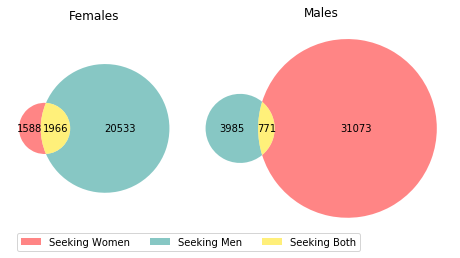

In [7]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
ax1 = plt.subplot2grid((1, 10), (0, 0), colspan=4)
f = matplotlib_venn.venn2(subsets = (1588, 20533, 1966), set_labels = None, ax=ax1, alpha=0.7)
f.get_patch_by_id('01').set_color('#55B0AC')
f.get_patch_by_id('01').set_edgecolor('none')
f.get_patch_by_id('10').set_color('#FF5252')
f.get_patch_by_id('10').set_edgecolor('none')
f.get_patch_by_id('11').set_color('#FFEA42')
f.get_patch_by_id('11').set_edgecolor('none')
ax1.set_title('Females', y=1.18)
    
ax2 = plt.subplot2grid((1, 10), (0, 4), colspan=6)    
m = matplotlib_venn.venn2(subsets = (3985, 31073, 771), set_labels = None, ax=ax2, alpha=0.7)
m.get_patch_by_id('10').set_color('#55B0AC')
m.get_patch_by_id('10').set_edgecolor('none')
m.get_patch_by_id('01').set_color('#FF5252')
m.get_patch_by_id('01').set_edgecolor('none')
m.get_patch_by_id('11').set_color('#FFEA42')
m.get_patch_by_id('11').set_edgecolor('none')
ax2.set_title('Males')

h =[f.get_patch_by_id('10'), f.get_patch_by_id('01'), f.get_patch_by_id('11')]
plt.legend(h,['Seeking Women', 'Seeking Men', 'Seeking Both'], ncol=3, loc = 'lower center', bbox_to_anchor=(0, -.1))
plt.show()

In [8]:
#Cleaning Text
df['sign'] = df['sign'].apply(lambda x: re.sub('&rsquo;','\'', x) if x is not np.NaN else x)
df['offspring'] = df['offspring'].apply(lambda x: re.sub('&rsquo;','\'', x) if x is not np.NaN else x)


#Separate out Multiple Choice and Open-Ended responses
essays = [col for col in df.columns if "essay" in col]

#Clean Essays from HTML syntax
for essay in essays:
    df[essay]=df[essay].apply(lambda x: re.sub('\\\'','',re.sub('\\n',' ',re.sub('<.*>',' ', x))) if x is not np.NaN else x)
    df[essay+'_complete'] = df[essay].notnull()

df['completed essays'] = df[essays].notnull().sum(axis=1)

#Need to recapture the essay columns
essays = [col for col in df.columns if "essay" in col]

df_mc = df[[col for col in df.columns if col not in essays]]
df_short_answer = df[essays]


In [9]:
df_short_answer.groupby(df_short_answer.index).sum().sum()/len(df_short_answer)

#3,6,8 are the most challenging

essay0_complete     0.908451
essay1_complete     0.873686
essay2_complete     0.839222
essay3_complete     0.808561
essay4_complete     0.824225
essay5_complete     0.819004
essay6_complete     0.770277
essay7_complete     0.792296
essay8_complete     0.679295
essay9_complete     0.789761
completed essays    8.104778
dtype: float64

In [10]:
all_essay3 = " ".join(re.findall(r'[\w\s+]*'," ".join(list(df[df['essay3_complete']]['essay3'])))).split()

men_essay3 = " ".join(re.findall(r'[\w\s+]*'," ".join(list(df[(df['essay3_complete']) &  (df['sex']=='m')]['essay3'])))).split()
women_essay3 = " ".join(re.findall(r'[\w\s+]*'," ".join(list(df[(df['essay3_complete']) & (df['sex']=='f')]['essay3'])))).split()


In [11]:
# Initializing ALL Dictionary
all_essay3_d = {}

# counting number of times each word comes up in list of words (in dictionary)
for word in all_essay3: 
    all_essay3_d[word] = all_essay3_d.get(word, 0) + 1

# get the rate of occurence for that word     
for key, value in all_essay3_d.items():
    all_essay3_d[key] = value/len(all_essay3)
    
#######################################    
    
# Initializing MEN Dictionary
men_essay3_d = {}

# counting number of times each word comes up in list of words (in dictionary)
for word in men_essay3: 
    men_essay3_d[word] = men_essay3_d.get(word, 0) + 1

# get the rate of occurence for that word    
for key, value in men_essay3_d.items():
    men_essay3_d[key] = value/len(men_essay3)
    

####################################### 
# Initializing WOMEN Dictionary
women_essay3_d = {}

# counting number of times each word comes up in list of words (in dictionary)
for word in women_essay3: 
    women_essay3_d[word] = women_essay3_d.get(word, 0) + 1

# get the rate of occurence for that word     
for key, value in women_essay3_d.items():
    women_essay3_d[key] = value/len(women_essay3)
    

In [12]:
essay3_df = pd.DataFrame(columns=['Word','All','Men','Women'])

for word in all_essay3_d.keys():
    if len(word) > 3:
        essay3_df = essay3_df.append({'Word': word, 'All': all_essay3_d.get(word), 'Men': men_essay3_d.get(word), 'Women': women_essay3_d.get(word)}, ignore_index=True)

essay3_df.head()

,Word,All,Men,Women
0,look,0.003634,0.0039045,0.00322351
1,foot,0.000126,0.00013879,0.000105587
2,half,0.000278,0.00029595,0.000251546
3,asian,0.000720,0.000769469,0.000645945
4,caucasian,0.000016,2.04103e-05,9.31651e-06


In [13]:
essay3_df['Gender Diff'] = essay3_df['Women'] - essay3_df['Men']
essay3_df.head()

,Word,All,Men,Women,Gender Diff
0,look,0.003634,0.0039045,0.00322351,-0.000680984
1,foot,0.000126,0.00013879,0.000105587,-3.32031e-05
2,half,0.000278,0.00029595,0.000251546,-4.4404e-05
3,asian,0.000720,0.000769469,0.000645945,-0.000123525
4,caucasian,0.000016,2.04103e-05,9.31651e-06,-1.10938e-05


In [14]:
essay3_df=essay3_df.sort_values(by='Gender Diff', ascending=False).reset_index()

In [15]:
essay3_df['Abs Gender Diff'] = abs(essay3_df['Gender Diff'])
essay3_df.sort_values(by='Abs Gender Diff', ascending=False).head(10)#.reset_index()

,index,Word,All,Men,Women,Gender Diff,Abs Gender Diff
0,40,smile,0.013767,0.0100909,0.0193597,0.00926884,0.00926884
1,110,hair,0.007252,0.00565978,0.00967364,0.00401386,0.00401386
2,114,eyes,0.012113,0.0106011,0.0144126,0.00381152,0.00381152
3,23,laugh,0.003649,0.00251455,0.00537563,0.00286107,0.00286107
7715,25,that,0.019214,0.0198715,0.0182138,-0.00165772,0.00165772
7714,290,beard,0.000780,0.00127973,1.8633e-05,-0.00126109,0.00126109
4,65,short,0.001080,0.000616392,0.00178566,0.00116927,0.00116927
7713,652,tall,0.003122,0.00355548,0.00246266,-0.00109282,0.00109282
5,378,curly,0.000922,0.000571489,0.00145648,0.000884992,0.000884992
6,1954,girl,0.000491,0.000148995,0.00101239,0.000863399,0.000863399


In [16]:
essay3_df[essay3_df['Abs Gender Diff'].notnull()].sort_values(by='Gender Diff', ascending=False).tail(10)

,index,Word,All,Men,Women,Gender Diff,Abs Gender Diff
7706,138,about,0.004280,0.0044964,0.0039502,-0.000546195,0.000546195
7707,596,head,0.000738,0.000961327,0.000397504,-0.000563822,0.000563822
7708,130,dont,0.004840,0.0050883,0.00446261,-0.000625687,0.000625687
7709,329,humor,0.002815,0.00307788,0.00241608,-0.000661796,0.000661796
7710,0,look,0.003634,0.0039045,0.00322351,-0.000680984,0.000680984
7711,90,like,0.005699,0.0060088,0.00522656,-0.000782239,0.000782239
7712,197,good,0.003027,0.00335954,0.00252167,-0.000837872,0.000837872
7713,652,tall,0.003122,0.00355548,0.00246266,-0.00109282,0.00109282
7714,290,beard,0.000780,0.00127973,1.8633e-05,-0.00126109,0.00126109
7715,25,that,0.019214,0.0198715,0.0182138,-0.00165772,0.00165772


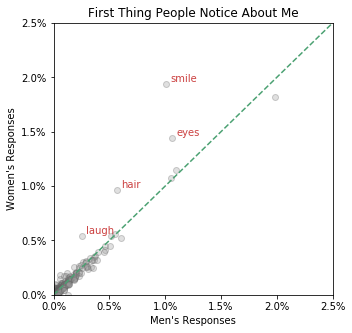

In [17]:
fig, ax = plt.subplots(figsize=(5,5))
plt.plot([0,0.5,1],[0,0.5,1], color='#4BA172', linestyle='--')
plt.scatter(essay3_df['Men'], essay3_df['Women'], color='#999999',edgecolors='#616161', label=essay3_df['Word'], alpha=0.3)
plt.xlabel('Men\'s Responses')
plt.ylabel('Women\'s Responses')
plt.title('First Thing People Notice About Me')
ticks = [i/1000 for i in range(0,26,5)]
ax.set_xticks(ticks)
ax.set_xticklabels(['{:.1f}%'.format(i*100) for i in ticks])
ax.set_yticklabels(['{:.1f}%'.format(i*100) for i in ticks])
ax.set_xlim(0,0.025)
ax.set_ylim(0,0.025)

for i, txt in enumerate(essay3_df['Word'][:4]):
    ax.annotate(txt, (essay3_df['Men'][i]+.0004, essay3_df['Women'][i]+.0002), color='#CC4141')
    
plt.show()

## Gay vs. Straight Men

In [18]:
straight_men_essay3 = " ".join(re.findall(r'[\w\s+]*'," ".join(list(df[(df['essay3_complete']) &  (df['sex']=='m') & (df['orientation']=='straight')]['essay3'])))).split()
gay_men_essay3 = " ".join(re.findall(r'[\w\s+]*'," ".join(list(df[(df['essay3_complete']) & (df['sex']=='m') & (df['orientation']=='gay')]['essay3'])))).split()

#######################################    
    
# Initializing STRAIGHT MEN Dictionary
straight_men_essay3_d = {}

# counting number of times each word comes up in list of words (in dictionary)
for word in straight_men_essay3: 
    straight_men_essay3_d[word] = straight_men_essay3_d.get(word, 0) + 1

# get the rate of occurence for that word    
for key, value in straight_men_essay3_d.items():
    straight_men_essay3_d[key] = value/len(straight_men_essay3)
    

####################################### 
# Initializing GAY MEN Dictionary
gay_men_essay3_d = {}

# counting number of times each word comes up in list of words (in dictionary)
for word in gay_men_essay3: 
    gay_men_essay3_d[word] = gay_men_essay3_d.get(word, 0) + 1

# get the rate of occurence for that word     
for key, value in gay_men_essay3_d.items():
    gay_men_essay3_d[key] = value/len(gay_men_essay3)

In [19]:
men_orientation_essay3_df = pd.DataFrame(columns=['Word','Men','Straight','Gay'])

for word in men_essay3_d.keys():
    if len(word) > 3:
        men_orientation_essay3_df = men_orientation_essay3_df.append({'Word': word, 'Men': men_essay3_d.get(word), 'Straight': straight_men_essay3_d.get(word), 'Gay': gay_men_essay3_d.get(word)}, ignore_index=True)

men_orientation_essay3_df.head()

,Word,Men,Straight,Gay
0,look,0.003904,0.00399822,0.00334242
1,foot,0.000139,0.000150561,7.26612e-05
2,half,0.000296,0.000303511,0.000254314
3,asian,0.000769,0.000781482,0.000853769
4,caucasian,0.000020,2.38985e-05,None


In [20]:
men_orientation_essay3_df['Diff'] = men_orientation_essay3_df['Gay'] - men_orientation_essay3_df['Straight']
men_orientation_essay3_df=men_orientation_essay3_df.sort_values(by='Diff', ascending=False).reset_index()
men_orientation_essay3_df.head()

,index,Word,Men,Straight,Gay,Diff
0,40,smile,0.010091,0.00933954,0.0169301,0.00759052
1,90,eyes,0.010601,0.0102405,0.0140418,0.00380127
2,14,people,0.010526,0.0103361,0.0120436,0.00170749
3,23,laugh,0.002515,0.00234205,0.00385104,0.00150899
4,73,think,0.003486,0.00337925,0.00430518,0.000925927


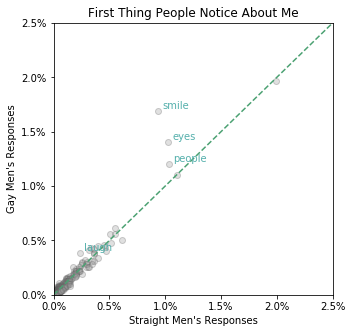

In [21]:
fig, ax = plt.subplots(figsize=(5,5))
plt.plot([0,0.5,1],[0,0.5,1], color='#4BA172', linestyle='--')
plt.scatter(men_orientation_essay3_df['Straight'], men_orientation_essay3_df['Gay'], color='#999999',edgecolors='#616161', label=essay3_df['Word'], alpha=0.3)
plt.xlabel('Straight Men\'s Responses')
plt.ylabel('Gay Men\'s Responses')
plt.title('First Thing People Notice About Me')
ticks = [i/1000 for i in range(0,26,5)]
ax.set_xticks(ticks)
ax.set_xticklabels(['{:.1f}%'.format(i*100) for i in ticks])
ax.set_yticklabels(['{:.1f}%'.format(i*100) for i in ticks])
ax.set_xlim(0,0.025)
ax.set_ylim(0,0.025)

for i, txt in enumerate(men_orientation_essay3_df['Word'][:4]):
    ax.annotate(txt, (men_orientation_essay3_df['Straight'][i]+.0004, men_orientation_essay3_df['Gay'][i]+.0002), color='#55B0AC')
    
plt.show()

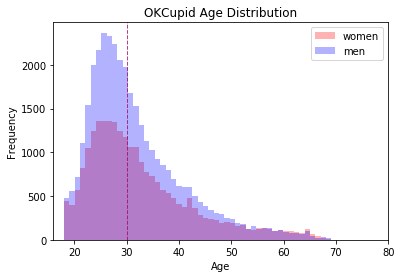

In [22]:
plt.hist([df_mc[df_mc.sex == 'm'].age, df_mc[df_mc.sex == 'f'].age], bins=90, histtype='stepfilled', alpha=0.3, color = ['blue', 'red'], label = ['men', 'women'])
plt.axvline(df_mc[df_mc.sex == 'm'].age.median(), color='blue', linestyle='dashed', linewidth=1, alpha=0.5)
plt.axvline(df_mc[df_mc.sex == 'f'].age.median(), color='red', linestyle='dashed', linewidth=1, alpha=0.5)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("OKCupid Age Distribution")
plt.legend()
plt.xlim(16, 80)
plt.show()

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


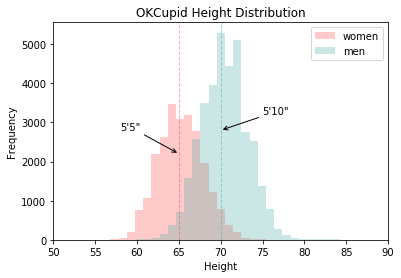

In [23]:
plt.hist([df_mc[df_mc.sex == 'm'].height, df_mc[df_mc.sex == 'f'].height], bins=96, histtype='stepfilled',alpha=0.3, color = ['#55B0AC', '#FF5252'], label = ['men', 'women'])
#only 96 bins and not 100, because there is a weird gap when I do 100

plt.axvline(df_mc[df_mc.sex == 'm'].height.median(), color='#55B0AC', linestyle='dashed', linewidth=1, alpha=0.5)
plt.axvline(df_mc[df_mc.sex == 'f'].height.median(), color='#FF5252', linestyle='dashed', linewidth=1, alpha=0.5)
plt.xlabel("Height")
plt.ylabel("Frequency")
plt.title("OKCupid Height Distribution")
plt.annotate('5\'5"', (65,2200),xytext=(58, 2800),arrowprops=dict(facecolor='black', arrowstyle="->"))
plt.annotate('5\'10"', (70,2800),xytext=(75, 3200),arrowprops=dict(facecolor='black', arrowstyle="->"))
plt.legend()
plt.xlim(50, 90)
plt.show()

In [24]:
df['tall']=df[df['essay3_complete']==True]['essay3'].apply(lambda x: 1 if 'tall' in x else 0)
df['short']=df[df['essay3_complete']==True]['essay3'].apply(lambda x: 1 if 'short' in x else 0)

short = df.groupby(['sex','short'])['height'].median().reset_index()
short['percentile of sex'] = short.apply(lambda row: percentileofscore(df[df['sex']==row['sex']]['height'],row['height']), axis=1)
short

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1795: RuntimeWarning: invalid value encountered in less
  left = np.count_nonzero(a < score)
/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1796: RuntimeWarning: invalid value encountered in less_equal
  right = np.count_nonzero(a <= score)


,sex,short,height,percentile of sex
0,f,0.0,65.0,49.649625
1,f,1.0,62.0,13.359871
2,m,0.0,70.0,43.565268
3,m,1.0,69.0,30.658126


In [25]:
sp = short[short['short']==1].pivot(columns='sex', index='short', values='percentile of sex').reset_index()
sp['short'] = 'short'
sp.rename(columns={'short':'height'}, inplace=True)
sp

sex,height,f,m
0,short,13.359871,30.658126


In [26]:
tall = df.groupby(['sex','tall'])['height'].median().reset_index()
tall['percentile of sex'] = tall.apply(lambda row: percentileofscore(df[df['sex']==row['sex']]['height'],row['height']), axis=1)
tall

,sex,tall,height,percentile of sex
0,f,0.0,65.0,49.649625
1,f,1.0,69.0,91.445868
2,m,0.0,70.0,43.565268
3,m,1.0,74.0,88.907031


In [27]:
tp = tall.pivot(columns='sex', index='tall', values='percentile of sex').reset_index()
tp.rename(columns={'tall':'height'}, inplace=True)
tp['height'] = ['average', 'tall']
tp

sex,height,f,m
0,average,49.649625,43.565268
1,tall,91.445868,88.907031


In [28]:
heights_tile = sp.append(tp)
heights_tile

sex,height,f,m
0,short,13.359871,30.658126
0,average,49.649625,43.565268
1,tall,91.445868,88.907031


In [29]:
heights_tile['m height with f tile'] = heights_tile['f'].apply(lambda x: np.nanpercentile(df[df['sex']=='m']['height'], x))
heights_tile['f height with m tile'] = heights_tile['m'].apply(lambda x: np.nanpercentile(df[df['sex']=='f']['height'], x))
heights_tile

sex,height,f,m,m height with f tile,f height with m tile
0,short,13.359871,30.658126,67.0,64.0
0,average,49.649625,43.565268,70.0,65.0
1,tall,91.445868,88.907031,74.0,68.0


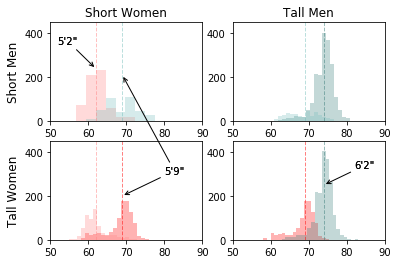

In [30]:
fig, ax = plt.subplots(2, 2)

plt.subplot(2,2,1)
plt.hist([df[(df.sex == 'm') & (df.short == 1)].height, df[(df.sex == 'f') & (df.short == 1)].height], bins=20, histtype='stepfilled',alpha=0.3, color = ['#78c0bd', '#ff8585'], label = ['short men', 'short women'])
plt.axvline(df[(df.sex == 'm') & (df.short == 1)].height.median(), color='#78c0bd', linestyle='dashed', linewidth=1, alpha=0.5)
plt.axvline(df[(df.sex == 'f') & (df.short == 1)].height.median(), color='#ff8585', linestyle='dashed', linewidth=1, alpha=0.5)
plt.ylabel("Short Men", fontsize= 12)
plt.title("Short Women", fontsize= 12)
plt.annotate('5\'2"', (62,240),xytext=(52, 350),arrowprops=dict(facecolor='black', arrowstyle="->"))
plt.annotate('5\'2"', (62,240),xytext=(52, 350))
plt.xlim(50, 90)
plt.ylim(0, 450)


plt.subplot(2,2,2)
plt.hist([df[(df.sex == 'm') & (df.short == 1)].height, df[(df.sex == 'm') & (df.tall == 1)].height], bins=50, histtype='stepfilled',alpha=0.3, color = ['#78c0bd', '#3b7e7b'], label = ['short men', 'tall men'])
plt.axvline(df[(df.sex == 'm') & (df.short == 1)].height.median(), color='#78c0bd', linestyle='dashed', linewidth=1, alpha=0.5)
plt.axvline(df[(df.sex == 'm') & (df.tall == 1)].height.median(), color='#3b7e7b', linestyle='dashed', linewidth=1, alpha=0.5)
plt.title("Tall Men", fontsize= 12)
plt.xlim(50, 90)
plt.ylim(0, 450)

plt.subplot(2,2,3)
plt.hist([df[(df.sex == 'f') & (df.short == 1)].height, df[(df.sex == 'f') & (df.tall == 1)].height], bins=20, histtype='stepfilled',alpha=0.3, color = ['#ff8585', '#ff0505'], label = ['short women', 'tall women'])
plt.axvline(df[(df.sex == 'f') & (df.short == 1)].height.median(), color='#ff8585', linestyle='dashed', linewidth=1, alpha=0.5)
plt.axvline(df[(df.sex == 'f') & (df.tall == 1)].height.median(), color='#ff0505', linestyle='dashed', linewidth=1, alpha=0.5)
plt.ylabel("Tall Women", fontsize= 12)
plt.annotate('5\'9"', (69,200),xytext=(80, 300),arrowprops=dict(facecolor='black', arrowstyle="->"))
plt.annotate('5\'9"', (69,750),xytext=(80, 300),arrowprops=dict(facecolor='black', arrowstyle="->"),annotation_clip=False)
plt.xlim(50, 90)
plt.ylim(0, 450)

plt.subplot(2,2,4)
plt.hist([df[(df.sex == 'm') & (df.tall == 1)].height, df[(df.sex == 'f') & (df.tall == 1)].height], bins=50, histtype='stepfilled',alpha=0.3, color = ['#3b7e7b', '#ff0505'], label = ['tall men', 'tall women'])
plt.axvline(df[(df.sex == 'm') & (df.tall == 1)].height.median(), color='#3b7e7b', linestyle='dashed', linewidth=1, alpha=0.5)
plt.axvline(df[(df.sex == 'f') & (df.tall == 1)].height.median(), color='#ff0505', linestyle='dashed', linewidth=1, alpha=0.5)
plt.annotate('6\'2"', (74,250),xytext=(82, 325),arrowprops=dict(facecolor='black', arrowstyle="->"))
plt.annotate('6\'2"', (74,250),xytext=(82, 325))
plt.xlim(50, 90)
plt.ylim(0, 450)


h =[f.get_patch_by_id('10'), f.get_patch_by_id('01'), f.get_patch_by_id('11')]
#plt.legend(h,['Seeking Women', 'Seeking Men', 'Seeking Both'], ncol=3, loc = 'lower center', bbox_to_anchor=(0, -.1))


plt.show()



In [31]:
df_mc['body_type'].fillna('no response', inplace=True)

body_table = df_mc.groupby(['body_type', 'sex'])['income'].count().reset_index()
body_pivot = body_table.pivot(index = 'body_type', columns = 'sex', values = 'income').reset_index()
body_pivot['total'] = body_pivot['m'] + body_pivot['f']

body_pivot['% of body_type: f'] = body_pivot['f']/body_pivot['total']
body_pivot['% of body_type: m'] = body_pivot['m']/body_pivot['total']

body_pivot['% f with body_type'] = body_pivot['f'].apply(lambda x: x/body_pivot['f'].sum())
body_pivot['% m with body_type'] = body_pivot['m'].apply(lambda x: x/body_pivot['m'].sum())
body_pivot['% total with body_type'] = body_pivot['total'].apply(lambda x: x/body_pivot['total'].sum())

body_pivot['difference in %'] = body_pivot['% f with body_type'] - body_pivot['% m with body_type']

body_pivot['female index'] = body_pivot['% f with body_type']/body_pivot['% total with body_type']
body_pivot['male index'] = body_pivot['% m with body_type']/body_pivot['% total with body_type']

body_pivot.sort_values(by='female index', ascending=False, inplace=True)
body_pivot

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


sex,body_type,f,m,total,% of body_type: f,% of body_type: m,% f with body_type,% m with body_type,% total with body_type,difference in %,female index,male index
3,curvy,3811,113,3924,0.971203,0.028797,0.158021,0.003154,0.065459,0.154867,2.414053,0.048181
5,full figured,870,139,1009,0.862240,0.137760,0.036074,0.003880,0.016832,0.032195,2.143211,0.230488
9,rather not say,106,92,198,0.535354,0.464646,0.004395,0.002568,0.003303,0.001827,1.330692,0.777406
11,thin,2469,2242,4711,0.524093,0.475907,0.102376,0.062575,0.078587,0.039801,1.302701,0.796247
7,no response,2703,2593,5296,0.510385,0.489615,0.112079,0.072372,0.088346,0.039707,1.268630,0.819181
2,average,5620,9032,14652,0.383565,0.616435,0.233031,0.252086,0.244420,-0.019056,0.953403,1.031365
4,fit,4431,8280,12711,0.348596,0.651404,0.183729,0.231098,0.212041,-0.047368,0.866481,1.089874
10,skinny,601,1176,1777,0.338210,0.661790,0.024920,0.032823,0.029643,-0.007902,0.840667,1.107249
8,overweight,145,299,444,0.326577,0.673423,0.006012,0.008345,0.007407,-0.002333,0.811749,1.126714
0,a little extra,821,1808,2629,0.312286,0.687714,0.034042,0.050462,0.043856,-0.016420,0.776228,1.150624


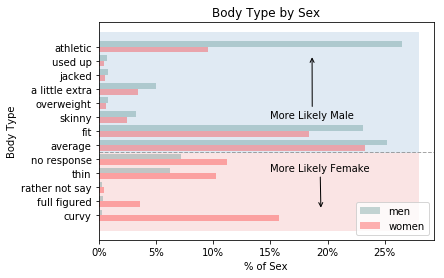

In [32]:
fig, ax = plt.subplots()

n = 1  # This is our first dataset (out of 2)
t = 2 # Number of datasets
d = len(body_pivot['body_type'].unique()) # Number of sets of bars
w = 0.8 # Width of each bar
female_x = [t*element + w*n for element in range(d)]

n = 2
male_x = [t*element + w*n for element in range(d)]

n = 1.5
ticks = [t*element + w*n for element in range(d)]

plt.barh(male_x,body_pivot['% m with body_type'], alpha=0.3, label='men', color='#3b7e7b')
plt.barh(female_x,body_pivot['% f with body_type'], alpha=0.3, label='women', color='#ff0505')
plt.axhline(10.25, color='gray', linestyle='dashed', linewidth=1, alpha=0.7)
#plt.axhline(18.25, color='gray', linestyle='dashed', linewidth=1, alpha=0.7)

percent = [i/100 for i in range(0,26,5)]
ax.set_xticks(percent)
ax.set_xticklabels(['{:.0f}%'.format(i*100) for i in percent])

plt.xlabel("% of Sex")
plt.ylabel("Body Type")
plt.title("Body Type by Sex")
plt.legend()
plt.yticks(ticks = ticks, labels=body_pivot["body_type"])


xlim=np.array(plt.gca().get_xlim())
ylim=np.array(plt.gca().get_ylim())

fb1 = plt.fill_between(xlim, y1=10.25, y2=[ylim[0],ylim[0]], color="#fae4e4", zorder=0 )
fb2 = plt.fill_between(xlim, y1=10.25, y2=[ylim[1],ylim[1]], color="#e0eaf3", zorder=0 )

plt.annotate('More Likely Male', (.1865,24),xytext=(.15, 15),arrowprops=dict(facecolor='black', arrowstyle="->"))
plt.annotate('More Likely Femake', (.1942,2),xytext=(.15, 7.5),arrowprops=dict(facecolor='black', arrowstyle="->"))


plt.show()

In [33]:
contingency_table = body_pivot[['body_type','f','m']].set_index('body_type').transpose()
contingency_table

body_type,curvy,full figured,rather not say,thin,no response,average,fit,skinny,overweight,a little extra,jacked,used up,athletic
sex,,,,,,,,,,,,,
f,3811,870,106,2469,2703,5620,4431,601,145,821,129,102,2309
m,113,139,92,2242,2593,9032,8280,1176,299,1808,292,253,9510


In [34]:
chi2, pval, dof, expected = chi2_contingency(contingency_table)
print(pval)

0.0


In [35]:
for btype in [i for i in df_mc['body_type'].unique() if i is not np.NaN]:
    m_yes = sum(list(df_mc[df_mc['sex']=='m']['body_type']==btype))
    m_total = len(list(df_mc[df_mc['sex']=='m']['body_type']==btype))
    
    f_yes = sum(list(df_mc[df_mc['sex']=='f']['body_type']==btype))
    f_total = len(list(df_mc[df_mc['sex']=='f']['body_type']==btype))
    
    contingency_table = pd.DataFrame(columns=['sex',btype, 'not '+btype])
    contingency_table = contingency_table.append({'sex':'m', btype: m_yes, 'not '+btype:m_total-m_yes}, ignore_index=True)
    contingency_table = contingency_table.append({'sex':'f', btype: f_yes, 'not '+btype:f_total-f_yes}, ignore_index=True)
    contingency_table.set_index('sex', inplace=True)

    chi2, pval, dof, expected = chi2_contingency(contingency_table)
    print(btype, '{0:.5f}'.format(pval), pval <=0.05 )
    

a little extra 0.00000 True
average 0.00000 True
thin 0.00000 True
athletic 0.00000 True
fit 0.00000 True
no response 0.00000 True
skinny 0.00000 True
curvy 0.00000 True
full figured 0.00000 True
jacked 0.00007 True
rather not say 0.00018 True
used up 0.00001 True
overweight 0.00129 True


In [36]:
df_mc['diet'].fillna('no response', inplace=True)

diet_options = list(df_mc.diet.unique())
final_diet = ["anything", "vegetarian", "vegan", "kosher", "halal", "other"]

diet_dict = {}
for diet in final_diet:
    for option in diet_options:
        if diet in option:
            diet_dict[option] = diet
            
#print(diet_dict)

df_mc["diet_final"] = df_mc["diet"].map(diet_dict)#.fillna(df_mc['diet'])
    
    

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [37]:
diet_table = df_mc.groupby(['diet_final'])['income'].count().reset_index()
diet_table.sort_values(by='income', ascending=False)

,diet_final,income
0,anything,27881
5,vegetarian,4986
3,other,1790
4,vegan,702
2,kosher,115
1,halal,77


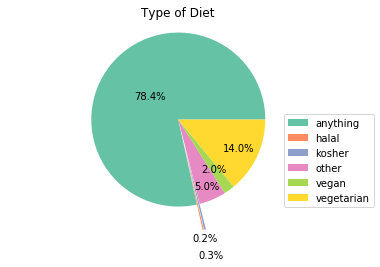

In [38]:
colors = sns.color_palette("Set2")

w,l,p = plt.pie(diet_table['income'], autopct='%1.1f%%', colors = colors, pctdistance=0.7, explode=(0,.3,.3,0,0,0))
plt.title('Type of Diet')
plt.legend(labels=diet_table['diet_final'], bbox_to_anchor=(0.8, 0.6), ncol=1)

pctdists = [.6, 1.4, 1.6, 1.2, 1.0, 1.1]

for t,d in zip(p, pctdists):
    xi,yi = t.get_position()
    ri = np.sqrt(xi**2+yi**2)
    phi = np.arctan2(yi,xi)
    x = d*ri*np.cos(phi)
    y = d*ri*np.sin(phi)
    t.set_position((x,y))

plt.axis('equal')
plt.show()

In [39]:
df_mc['cats'] = df_mc['pets'].apply(lambda x: x.split()[x.split().index('cats')-1] if (isinstance(x, str)) & ('cats' in str(x)) else 0)
df_mc['dogs'] = df_mc['pets'].apply(lambda x: x.split()[x.split().index('dogs')-1] if (isinstance(x, str)) & ('dogs' in str(x)) else 0)
df_mc[['pets', 'cats', 'dogs']]

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,pets,cats,dogs
0,likes dogs and likes cats,likes,likes
1,likes dogs and likes cats,likes,likes
2,has cats,has,0
3,likes cats,likes,0
4,likes dogs and likes cats,likes,likes
5,likes cats,likes,0
6,likes dogs and likes cats,likes,likes
7,likes dogs and likes cats,likes,likes
8,likes dogs and likes cats,likes,likes
9,likes dogs and likes cats,likes,likes


In [40]:
df_mc.groupby(['diet_final','dogs'])['age'].count()#.reset_index()

diet_final  dogs    
anything    0            8815
            dislikes      221
            has          4204
            likes       14641
halal       0              40
            dislikes       11
            has             6
            likes          20
kosher      0              33
            dislikes        7
            has            16
            likes          59
other       0             553
            dislikes       26
            has           298
            likes         913
vegan       0             226
            dislikes       12
            has            94
            likes         370
vegetarian  0            1667
            dislikes       58
            has           688
            likes        2573
Name: age, dtype: int64

In [41]:
cats = df_mc[df_mc['cats']!=0].groupby('cats')['age'].count()/df_mc[df_mc['pets'].notnull()]['age'].count()
cats.reset_index()

,cats,age
0,dislikes,0.072430
1,has,0.181736
2,likes,0.460962


In [42]:
dogs = df_mc[df_mc['dogs']!=0].groupby('dogs')['age'].count()/df_mc[df_mc['pets'].notnull()]['age'].count()
dogs.reset_index()

,dogs,age
0,dislikes,0.014016
1,has,0.212192
2,likes,0.709057


In [43]:
diet_dogs = df_mc[df_mc['dogs']!=0].groupby(['diet_final','dogs'])['age'].count()/df_mc[df_mc['pets'].notnull()].groupby('diet_final')['age'].count()
diet_dogs=diet_dogs.reset_index()
diet_dogs_pivot = diet_dogs.pivot(index='diet_final', columns='dogs', values='age').sort_values(by='dislikes', ascending=True).reset_index()
diet_dogs_pivot

dogs,diet_final,dislikes,has,likes
0,anything,0.010985,0.208967,0.727756
1,vegetarian,0.016018,0.190003,0.710577
2,other,0.019461,0.223054,0.683383
3,vegan,0.022989,0.180077,0.708812
4,kosher,0.076087,0.173913,0.641304
5,halal,0.261905,0.142857,0.476190


In [44]:
diet_cats = df_mc[df_mc['cats']!=0].groupby(['diet_final','cats'])['age'].count()/df_mc[df_mc['pets'].notnull()].groupby('diet_final')['age'].count()
diet_cats=diet_cats.reset_index()
diet_cats_pivot = diet_cats.pivot(index='diet_final', columns='cats', values='age').sort_values(by='dislikes', ascending=True).reset_index()
diet_cats_pivot

cats,diet_final,dislikes,has,likes
0,vegan,0.044061,0.239464,0.578544
1,vegetarian,0.051367,0.219276,0.508699
2,other,0.077096,0.205838,0.479042
3,anything,0.082165,0.160801,0.469878
4,kosher,0.163043,0.315217,0.434783
5,halal,0.261905,0.142857,0.452381


In [45]:
df_mc['religion_high_level'] = df_mc.religion.apply(lambda x: x.split()[0] if isinstance(x, str) else 'no response') 
df_mc['religion_attitude'] = df_mc.religion.apply(lambda x: " ".join(x.split()[1:]) if isinstance(x, str) else 'no response')
df_mc['religion_attitude'].replace('', 'no response', inplace=True)


/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.o

In [46]:
religion_dogs = df_mc[df_mc['dogs']!=0].groupby(['religion_high_level','dogs'])['age'].count()/df_mc[df_mc['pets'].notnull()].groupby('religion_high_level')['age'].count()
religion_dogs=religion_dogs.reset_index()
religion_dogs_pivot = religion_dogs.pivot(index='religion_high_level', columns='dogs', values='age').sort_values(by='dislikes', ascending=True).reset_index()
religion_dogs_pivot

dogs,religion_high_level,dislikes,has,likes
0,no response,0.007128,0.239100,0.690086
1,judaism,0.010884,0.206349,0.734694
2,catholicism,0.011170,0.286596,0.669312
3,buddhism,0.012784,0.202415,0.704545
4,agnosticism,0.014138,0.171576,0.746244
5,other,0.014867,0.198006,0.713803
6,christianity,0.017662,0.257463,0.679851
7,atheism,0.022622,0.154486,0.730278
8,hinduism,0.049327,0.067265,0.834081
9,islam,0.253012,0.108434,0.578313


In [47]:
religion_cats = df_mc[df_mc['cats']!=0].groupby(['religion_high_level','cats'])['age'].count()/df_mc[df_mc['pets'].notnull()].groupby('religion_high_level')['age'].count()
religion_cats=religion_cats.reset_index()
religion_cats_pivot = religion_cats.pivot(index='religion_high_level', columns='cats', values='age').sort_values(by='dislikes', ascending=True).reset_index()
religion_cats_pivot

cats,religion_high_level,dislikes,has,likes
0,atheism,0.055878,0.203016,0.549884
1,other,0.055922,0.223855,0.519344
2,no response,0.058965,0.162455,0.408868
3,agnosticism,0.060530,0.205891,0.511635
4,buddhism,0.063210,0.192472,0.487926
5,judaism,0.082540,0.181406,0.400454
6,catholicism,0.119929,0.127572,0.382716
7,christianity,0.124378,0.151244,0.412189
8,hinduism,0.161435,0.080717,0.340807
9,islam,0.192771,0.180723,0.433735


/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/Users/kerrydriscoll/anaconda/lib/python3.6/site

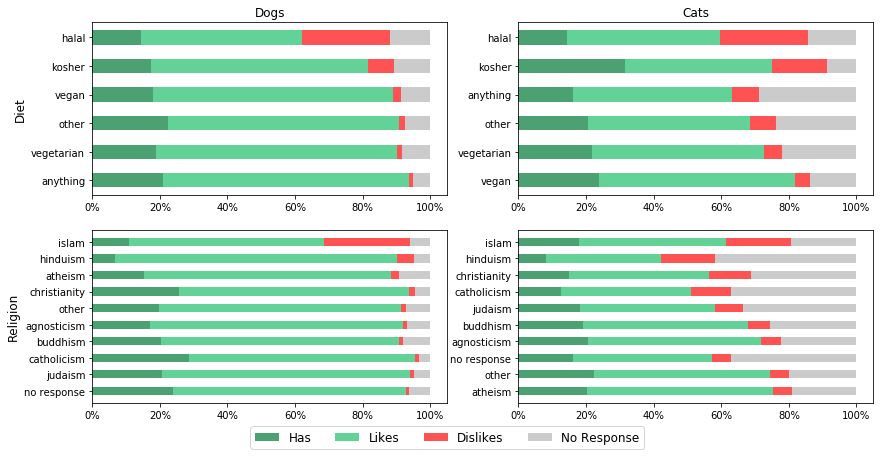

In [48]:
fig, ax = plt.subplots(2, 2, figsize=(14,7))
width = 0.5

plt.subplot(2,2,1)
ax1 = plt.subplot(2,2,1)
ind = diet_dogs_pivot['diet_final']
dataset1 = np.array(diet_dogs_pivot['has'])
dataset2 = np.array(diet_dogs_pivot['likes'])
dataset3 = np.array(diet_dogs_pivot['dislikes'])
dataset4 = 1- (dataset1+dataset2+dataset3)
plt.title('Dogs')
plt.ylabel('Diet', fontsize=12)
p1 = plt.barh(ind, dataset1, width, color='#4BA172')
p2 = plt.barh(ind, dataset2, width, left=dataset1, color='#63D297')
p3 = plt.barh(ind, dataset3, width, left=dataset1+dataset2, color='#FF5252')
p4 = plt.barh(ind, dataset4, width, left=dataset1+dataset2+dataset3, color='#999999', alpha=0.5)

percent = [i/100 for i in range(0,101,20)]
ax1.set_xticks(percent)
ax1.set_xticklabels(['{:.0f}%'.format(i*100) for i in percent])

plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Has', 'Likes', 'Dislikes', 'No Response'), fontsize=12, ncol=4, loc = 'lower center', bbox_to_anchor=(1, -1.5))

plt.subplot(2,2,2)
ax2 = plt.subplot(2,2,2)
ind = diet_cats_pivot['diet_final']
dataset1 = np.array(diet_cats_pivot['has'])
dataset2 = np.array(diet_cats_pivot['likes'])
dataset3 = np.array(diet_cats_pivot['dislikes'])
dataset4 = 1- (dataset1+dataset2+dataset3)
plt.title('Cats')
p1 = plt.barh(ind, dataset1, width, color='#4BA172')
p2 = plt.barh(ind, dataset2, width, left=dataset1, color='#63D297')
p3 = plt.barh(ind, dataset3, width, left=dataset1+dataset2, color='#FF5252')
p4 = plt.barh(ind, dataset4, width, left=dataset1+dataset2+dataset3, color='#999999', alpha=0.5)
ax2.set_xticklabels(['{:.0f}%'.format(i*100) for i in percent])


plt.subplot(2,2,3)
ax3 = plt.subplot(2,2,3)
ind = religion_dogs_pivot['religion_high_level']
dataset1 = np.array(religion_dogs_pivot['has'])
dataset2 = np.array(religion_dogs_pivot['likes'])
dataset3 = np.array(religion_dogs_pivot['dislikes'])
dataset4 = 1- (dataset1+dataset2+dataset3)
#plt.title('Dogs')
plt.ylabel('Religion', fontsize=12)
p1 = plt.barh(ind, dataset1, width, color='#4BA172')
p2 = plt.barh(ind, dataset2, width, left=dataset1, color='#63D297')
p3 = plt.barh(ind, dataset3, width, left=dataset1+dataset2, color='#FF5252')
p4 = plt.barh(ind, dataset4, width, left=dataset1+dataset2+dataset3, color='#999999', alpha=0.5)
ax3.set_xticklabels(['{:.0f}%'.format(i*100) for i in percent])



plt.subplot(2,2,4)
ax4 = plt.subplot(2,2,4)
ind = religion_cats_pivot['religion_high_level']
dataset1 = np.array(religion_cats_pivot['has'])
dataset2 = np.array(religion_cats_pivot['likes'])
dataset3 = np.array(religion_cats_pivot['dislikes'])
dataset4 = 1- (dataset1+dataset2+dataset3)
#plt.title('Cats')
p1 = plt.barh(ind, dataset1, width, color='#4BA172')
p2 = plt.barh(ind, dataset2, width, left=dataset1, color='#63D297')
p3 = plt.barh(ind, dataset3, width, left=dataset1+dataset2, color='#FF5252')
p4 = plt.barh(ind, dataset4, width, left=dataset1+dataset2+dataset3, color='#999999', alpha=0.5)
ax4.set_xticklabels(['{:.0f}%'.format(i*100) for i in percent])



plt.show()

In [49]:
df_mc['has_pets'] = df_mc.pets.apply(lambda x: 1 if isinstance(x, str) and ('has' in x) else 0)
df_mc['dislikes_some_pets'] = df_mc.pets.apply(lambda x: 1 if isinstance(x, str) and ('dislikes' in x) else 0)
df_mc[['pets','has_pets', 'dislikes_some_pets']].head()

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,pets,has_pets,dislikes_some_pets
0,likes dogs and likes cats,0,0
1,likes dogs and likes cats,0,0
2,has cats,1,0
3,likes cats,0,0
4,likes dogs and likes cats,0,0


In [50]:
df_mc[['has_pets', 'dislikes_some_pets']].describe()

,has_pets,dislikes_some_pets
count,59946.000000,59946.000000
mean,0.238431,0.054449
std,0.426128,0.226903
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [51]:
df_mc.groupby(['diet_final'])['has_pets'].describe()[['count', 'mean']].sort_values(by='mean', ascending=False)

,count,mean
diet_final,,
kosher,115.0,0.321739
vegan,702.0,0.292023
other,1790.0,0.288268
vegetarian,4986.0,0.267549
anything,27881.0,0.241921
halal,77.0,0.142857


In [52]:
df_mc.groupby(['diet_final'])['dislikes_some_pets'].describe()[['count', 'mean']].sort_values(by='mean')

,count,mean
diet_final,,
vegan,702.0,0.044160
vegetarian,4986.0,0.045929
anything,27881.0,0.064237
other,1790.0,0.065922
kosher,115.0,0.156522
halal,77.0,0.194805


In [53]:
df_mc.groupby(['religion_high_level'])['dislikes_some_pets'].describe()[['count', 'mean']].sort_values(by='mean')

,count,mean
religion_high_level,,
no response,20226.0,0.033670
other,7743.0,0.051014
buddhism,1948.0,0.051848
agnosticism,8812.0,0.054585
atheism,6985.0,0.054832
judaism,3098.0,0.063912
catholicism,4758.0,0.089744
christianity,5787.0,0.091585
hinduism,450.0,0.093333


In [54]:
df_mc.groupby(['religion_high_level'])['has_pets'].describe()[['count', 'mean']].sort_values(by='mean', ascending=False)
#race_opt

,count,mean
religion_high_level,,
other,7743.0,0.285936
catholicism,4758.0,0.268390
agnosticism,8812.0,0.265093
buddhism,1948.0,0.255647
christianity,5787.0,0.253326
judaism,3098.0,0.252744
atheism,6985.0,0.242233
no response,20226.0,0.196430
islam,139.0,0.151079


In [55]:
df_mc['race_count']=df_mc['ethnicity'].apply(lambda x: len(x.split(',') )if x is not np.NaN else x)
race_opt = [i.strip() for i in df_mc[df_mc['race_count']==9]['ethnicity'].reset_index()['ethnicity'][0].split(',')]

for i in race_opt:
    df_mc[i] = df_mc['ethnicity'].apply(lambda x: 1 if (x is not np.NaN) and (i in x) else 0)
    
race_opt

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


['asian',
 'middle eastern',
 'black',
 'native american',
 'indian',
 'pacific islander',
 'hispanic / latin',
 'white',
 'other']

In [56]:
for i in race_opt:
    #print(df_mc[df_mc[i]==1].groupby(i)['dislikes_some_pets'].describe()[['count', 'mean']].sort_values(by='mean', ascending=False))
    print(df_mc.groupby(i)['dislikes_some_pets'].describe()[['count', 'mean']].sort_values(by='mean', ascending=False))



         count      mean
asian                   
1       8205.0  0.059354
0      51741.0  0.053671
                  count      mean
middle eastern                   
1                 950.0  0.056842
0               58996.0  0.054410
         count      mean
black                   
1       3328.0  0.090445
0      56618.0  0.052333
                   count      mean
native american                   
1                 1265.0  0.078261
0                58681.0  0.053936
          count      mean
indian                   
1        1449.0  0.062112
0       58497.0  0.054259
                    count      mean
pacific islander                   
1                  1473.0  0.075356
0                 58473.0  0.053922
                    count      mean
hispanic / latin                   
1                  5357.0  0.065148
0                 54589.0  0.053399
         count      mean
white                   
0      22064.0  0.058874
1      37882.0  0.051872
         count      mean
other  

In [57]:
for i in race_opt:
    #print(df_mc[df_mc[i]==1].groupby(i)['has_pets'].describe()[['count', 'mean']].sort_values(by='mean', ascending=False))
    print(df_mc.groupby(i)['has_pets'].describe()[['count', 'mean']].sort_values(by='mean', ascending=False))


         count      mean
asian                   
0      51741.0  0.247676
1       8205.0  0.180134
                  count      mean
middle eastern                   
0               58996.0  0.239084
1                 950.0  0.197895
         count      mean
black                   
0      56618.0  0.240613
1       3328.0  0.201322
                   count      mean
native american                   
1                 1265.0  0.293281
0                58681.0  0.237249
          count      mean
indian                   
0       58497.0  0.242200
1        1449.0  0.086266
                    count      mean
pacific islander                   
1                  1473.0  0.262050
0                 58473.0  0.237836
                    count      mean
hispanic / latin                   
1                  5357.0  0.266380
0                 54589.0  0.235689
         count      mean
white                   
1      37882.0  0.266512
0      22064.0  0.190219
         count      mean
other  

In [58]:
df_mc['religion_high_level'].value_counts()

no response     20226
agnosticism      8812
other            7743
atheism          6985
christianity     5787
catholicism      4758
judaism          3098
buddhism         1948
hinduism          450
islam             139
Name: religion_high_level, dtype: int64

In [59]:
df_mc['religion_attitude'].value_counts()
religion_att_map = {'and laughing about it':-1,'but not too serious about it':-1,
                    'no response':0, 
                    'and somewhat serious about it':1, 'and very serious about it':1}
df_mc['religion_attitude_num']=df_mc['religion_attitude'].map(religion_att_map)
#df_mc[['religion_attitude','religion_attitude_num']]

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [60]:
religion_table = df_mc.groupby(['religion_high_level', 'religion_attitude'])['income'].count().reset_index()
religion_pivot = religion_table.pivot(index = 'religion_high_level', columns = 'religion_attitude', values = 'income').reset_index()
religion_pivot.columns
religion_pivot = religion_pivot[['religion_high_level', 'and laughing about it','but not too serious about it', 'no response','and somewhat serious about it', 'and very serious about it']]
religion_pivot=religion_pivot[religion_pivot['religion_high_level']!='no response']
religion_pivot['total'] = religion_pivot.sum(axis=1)
religion_pivot


religion_attitude,religion_high_level,and laughing about it,but not too serious about it,no response,and somewhat serious about it,and very serious about it,total
0,agnosticism,2496.0,2636.0,2724.0,642.0,314.0,8812.0
1,atheism,2074.0,1318.0,2175.0,848.0,570.0,6985.0
2,buddhism,466.0,650.0,403.0,359.0,70.0,1948.0
3,catholicism,726.0,2318.0,1064.0,548.0,102.0,4758.0
4,christianity,373.0,1952.0,1957.0,927.0,578.0,5787.0
5,hinduism,44.0,227.0,107.0,58.0,14.0,450.0
6,islam,16.0,40.0,48.0,22.0,13.0,139.0
7,judaism,681.0,1517.0,612.0,266.0,22.0,3098.0
9,other,2119.0,1554.0,2691.0,846.0,533.0,7743.0


In [61]:
religion_table2 = df_mc.groupby(['religion_high_level', 'religion_attitude_num'])['income'].count().reset_index()
religion_pivot2 = religion_table2.pivot(index = 'religion_high_level', columns = 'religion_attitude_num', values = 'income').reset_index()
#religion_pivot2.columns
#religion_pivot2 = religion_pivot2[['religion_high_level', 'and laughing about it','but not too serious about it', 'no response','and somewhat serious about it', 'and very serious about it']]
religion_pivot2=religion_pivot2[religion_pivot2['religion_high_level']!='no response']
religion_pivot2['total'] = religion_pivot2.sum(axis=1)
religion_pivot2

religion_attitude_num,religion_high_level,-1,0,1,total
0,agnosticism,5132.0,2724.0,956.0,8812.0
1,atheism,3392.0,2175.0,1418.0,6985.0
2,buddhism,1116.0,403.0,429.0,1948.0
3,catholicism,3044.0,1064.0,650.0,4758.0
4,christianity,2325.0,1957.0,1505.0,5787.0
5,hinduism,271.0,107.0,72.0,450.0
6,islam,56.0,48.0,35.0,139.0
7,judaism,2198.0,612.0,288.0,3098.0
9,other,3673.0,2691.0,1379.0,7743.0


In [62]:
religion_pivot2['% -1'] = religion_pivot2[-1]/religion_pivot2['total']
religion_pivot2['% 0'] = religion_pivot2[0]/religion_pivot2['total']
religion_pivot2['% 1'] = religion_pivot2[1]/religion_pivot2['total']
religion_pivot2.sort_values(by='% 1', ascending=False, inplace=True)
religion_pivot2

religion_attitude_num,religion_high_level,-1,0,1,total,% -1,% 0,% 1
4,christianity,2325.0,1957.0,1505.0,5787.0,0.401763,0.338172,0.260066
6,islam,56.0,48.0,35.0,139.0,0.402878,0.345324,0.251799
2,buddhism,1116.0,403.0,429.0,1948.0,0.572895,0.206879,0.220226
1,atheism,3392.0,2175.0,1418.0,6985.0,0.485612,0.311382,0.203006
9,other,3673.0,2691.0,1379.0,7743.0,0.474364,0.347540,0.178096
5,hinduism,271.0,107.0,72.0,450.0,0.602222,0.237778,0.160000
3,catholicism,3044.0,1064.0,650.0,4758.0,0.639765,0.223623,0.136612
0,agnosticism,5132.0,2724.0,956.0,8812.0,0.582388,0.309124,0.108488
7,judaism,2198.0,612.0,288.0,3098.0,0.709490,0.197547,0.092963


In [63]:
openness_table = df_mc.groupby(['orientation', 'religion_attitude'])['income'].count().reset_index()
openness_pivot = openness_table.pivot(index = 'religion_attitude', columns = 'orientation', values = 'income').reset_index()
openness_pivot=openness_pivot[['religion_attitude','gay','bisexual','straight']]
openness_pivot['total'] = openness_pivot.sum(axis=1)
openness_pivot

orientation,religion_attitude,gay,bisexual,straight,total
0,and laughing about it,738,631,7626,8995
1,and somewhat serious about it,457,318,3741,4516
2,and very serious about it,225,164,1827,2216
3,but not too serious about it,1134,489,10589,12212
4,no response,3019,1165,27823,32007


In [64]:
openness_table2 = df_mc.groupby(['orientation', 'religion_high_level'])['income'].count().reset_index()
openness_pivot2 = openness_table2.pivot(index = 'religion_high_level', columns = 'orientation', values = 'income').reset_index()
openness_pivot2=openness_pivot2[['religion_high_level','gay','bisexual','straight']]
openness_pivot2['total'] = openness_pivot2.sum(axis=1)

openness_pivot2['% gay'] = openness_pivot2['gay']/openness_pivot2['total']
openness_pivot2['% bi'] = openness_pivot2['bisexual']/openness_pivot2['total']
openness_pivot2['% straight'] = openness_pivot2['straight']/openness_pivot2['total']

openness_pivot2.sort_values(by='% gay', ascending=False, inplace=True)

openness_pivot2

orientation,religion_high_level,gay,bisexual,straight,total,% gay,% bi,% straight
2,buddhism,275,134,1539,1948,0.141170,0.068789,0.790041
9,other,828,620,6295,7743,0.106935,0.080072,0.812992
8,no response,1950,696,17580,20226,0.096411,0.034411,0.869178
1,atheism,663,510,5812,6985,0.094918,0.073014,0.832069
0,agnosticism,782,445,7585,8812,0.088743,0.050499,0.860758
3,catholicism,415,79,4264,4758,0.087222,0.016604,0.896175
7,judaism,232,129,2737,3098,0.074887,0.041640,0.883473
4,christianity,393,140,5254,5787,0.067911,0.024192,0.907897
6,islam,9,5,125,139,0.064748,0.035971,0.899281
5,hinduism,26,9,415,450,0.057778,0.020000,0.922222


In [65]:
openness_table3 = df_mc.groupby(['orientation', 'religion_attitude_num'])['income'].count().reset_index()
openness_pivot3 = openness_table3.pivot(index = 'orientation', columns = 'religion_attitude_num', values = 'income').reset_index()
openness_pivot3=openness_pivot3[['orientation',-1,0,1]]
openness_pivot3['total'] = openness_pivot3[-1] + openness_pivot3[0] + openness_pivot3[1]

openness_pivot3['% -1'] = openness_pivot3[-1]/openness_pivot3['total']
openness_pivot3['% 0'] = openness_pivot3[0]/openness_pivot3['total']
openness_pivot3['% 1'] = openness_pivot3[1]/openness_pivot3['total']

openness_pivot3

religion_attitude_num,orientation,-1,0,1,total,% -1,% 0,% 1
0,bisexual,1120,1165,482,2767,0.404771,0.421034,0.174196
1,gay,1872,3019,682,5573,0.335905,0.541719,0.122376
2,straight,18215,27823,5568,51606,0.352963,0.539143,0.107894


In [66]:
openness_table4 = df_mc.groupby(['orientation', 'religion_high_level','religion_attitude_num'])['income'].count().reset_index()
openness_pivot4 = openness_table4.pivot_table(index =['religion_high_level','orientation'] , columns='religion_attitude_num', values='income').reset_index()
openness_pivot4['total'] = openness_pivot4.apply(lambda row: np.nansum([row[-1],row[0],row[1]]), axis=1)

openness_pivot4['% -1'] = openness_pivot4[-1]/openness_pivot4['total']
openness_pivot4['% 0'] = openness_pivot4[0]/openness_pivot4['total']
openness_pivot4['% 1'] = openness_pivot4[1]/openness_pivot4['total']

openness_pivot4

religion_attitude_num,religion_high_level,orientation,-1,0,1,total,% -1,% 0,% 1
0,agnosticism,bisexual,274.0,105.0,66.0,445.0,0.615730,0.235955,0.148315
1,agnosticism,gay,443.0,251.0,88.0,782.0,0.566496,0.320972,0.112532
2,agnosticism,straight,4415.0,2368.0,802.0,7585.0,0.582070,0.312195,0.105735
3,atheism,bisexual,242.0,122.0,146.0,510.0,0.474510,0.239216,0.286275
4,atheism,gay,284.0,199.0,180.0,663.0,0.428356,0.300151,0.271493
5,atheism,straight,2866.0,1854.0,1092.0,5812.0,0.493118,0.318995,0.187887
6,buddhism,bisexual,84.0,17.0,33.0,134.0,0.626866,0.126866,0.246269
7,buddhism,gay,134.0,70.0,71.0,275.0,0.487273,0.254545,0.258182
8,buddhism,straight,898.0,316.0,325.0,1539.0,0.583496,0.205328,0.211176
9,catholicism,bisexual,45.0,14.0,20.0,79.0,0.569620,0.177215,0.253165


In [67]:
df_mc['city'] = df_mc.location.apply(lambda x: x.split(",")[0] if isinstance(x, str) else 'no response') 
df_mc['state'] = df_mc.location.apply(lambda x: " ".join(x.split(",")[1:]).strip() if isinstance(x, str) else 'no response')

us = ['alabama','alaska','arizona','arkansas',
'california','colorado','connecticut',
'delaware','florida','georgia','hawaii',
'idaho','illinois','indiana','iowa',
'kansas','kentucky','louisiana','maine',
'maryland','massachusetts','michigan','minnesota','mississippi','missouri','montana',
'nebraska','nevada','new hampshire','new jersey','new mexico','new york',
'north carolina','north dakota',
'ohio','oklahoma','oregon',
'pennsylvania','rhode island','south carolina','south dakota',
'tennessee','texas','utah','vermont',
'virginia','washington','west virginia',
'wisconsin','wyoming','district of columbia',
'puerto rico','guam','american samoa','u.s. virgin islands','northern mariana islands']

df_mc['american'] = df_mc['state'].apply(lambda x: 1 if x in us else 0)



/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [68]:
df_mc[df_mc['american']==0]

,age,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,...,native american,indian,pacific islander,hispanic / latin,white,other,religion_attitude_num,city,state,american
8997,26,full figured,anything,socially,never,graduated from college/university,white,68.0,-1,NaN,...,0,0,0,0,1,0,0,madrid,spain,0
11526,28,average,mostly anything,socially,never,graduated from law school,asian,69.0,60000,education / academia,...,0,0,0,0,0,0,-1,nha trang,vietnam,0
12151,29,fit,mostly other,socially,sometimes,NaN,white,68.0,-1,other,...,0,0,0,0,1,0,0,cork,ireland,0
17474,25,fit,no response,socially,NaN,graduated from college/university,other,65.0,-1,computer / hardware / software,...,0,0,0,0,0,1,0,edinburgh,united kingdom,0
18359,22,fit,no response,socially,never,graduated from college/university,white,73.0,-1,science / tech / engineering,...,0,0,0,0,1,0,-1,london,united kingdom,0
28036,33,curvy,strictly anything,often,never,graduated from college/university,"hispanic / latin, white",63.0,-1,artistic / musical / writer,...,0,0,0,1,1,0,-1,madrid,spain,0
42438,32,fit,mostly anything,socially,never,working on space camp,asian,63.0,60000,political / government,...,0,0,0,0,0,0,0,vancouver,british columbia canada,0
45346,46,average,no response,not at all,never,graduated from masters program,white,78.0,-1,education / academia,...,0,0,0,0,1,0,0,kassel,germany,0
50046,27,fit,anything,socially,never,graduated from college/university,white,72.0,-1,computer / hardware / software,...,0,0,0,0,1,0,0,amsterdam,netherlands,0
52196,26,average,mostly anything,socially,never,graduated from masters program,white,76.0,-1,science / tech / engineering,...,0,0,0,0,1,0,1,bonaduz,switzerland,0


In [69]:
df_mc['last_online'].min(),df_mc['last_online'].max()

('2011-06-27-01-52', '2012-07-01-08-57')

In [70]:
edu_options = list(df_mc['education'].unique())
edu_options = [edu for edu in edu_options if str(edu) != 'nan']
edu_options
edu_options_soup = " ".join(edu_options).split()

edu_options_double = []

for i in edu_options:
    for x in range(len(i.split()[:-1])):
        edu_options_double.append(i.split()[x] + " " + i.split()[x+1])

edu_options_double_count = {} 

for i in edu_options_double:
    if i not in edu_options_double_count:
        edu_options_double_count[i] = 1
    else:
        edu_options_double_count[i] += 1    
    
final_edu = []
for key, value in edu_options_double_count.items():
    if (value != 1) & (key != 'out of'):
        final_edu.append(key)
        
final_edu
final_edu_status = ['working on', 'graduated from','dropped out']
final_edu_level = [i for i in final_edu if i not in final_edu_status] + ['college/university']
print(final_edu_status)
print(final_edu_level)

['working on', 'graduated from', 'dropped out']
['space camp', 'masters program', 'two-year college', 'high school', 'ph.d program', 'law school', 'med school', 'college/university']


In [71]:
df_mc['education2']=df_mc['education'].fillna('')

df_mc['edu_progress']=df_mc['education2'].apply(lambda x: [i for i in final_edu_status if i in x][0] if len([i for i in final_edu_status if i in x])>0 else np.NaN)

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [72]:
df_mc['edu_level']=df_mc['education2'].apply(lambda x: [i for i in final_edu_level if i in x][0] if len([i for i in final_edu_level if i in x])>0 else np.NaN)

In [73]:
df_mc[['education','edu_progress', 'edu_level']].head(10)

,education,edu_progress,edu_level
0,working on college/university,working on,college/university
1,working on space camp,working on,space camp
2,graduated from masters program,graduated from,masters program
3,working on college/university,working on,college/university
4,graduated from college/university,graduated from,college/university
5,graduated from college/university,graduated from,college/university
6,graduated from college/university,graduated from,college/university
7,graduated from college/university,graduated from,college/university
8,graduated from college/university,graduated from,college/university
9,working on two-year college,working on,two-year college


In [74]:
edu_level_map = {'space camp':1, 'masters program':3, 'two-year college':1, 'high school':1, 'ph.d program':3, 'law school':3, 'med school':3, 'college/university':2}
df_mc['edu_level_num'] = df_mc['edu_level'].map(edu_level_map)

df_mc['edu_level_num']=df_mc.apply(lambda row: row['edu_level_num']-1 if (row['edu_progress']=='dropped out') & (row['edu_level']!='two-year college') else row['edu_level_num'], axis=1)

df_mc[['education', 'edu_progress','edu_level', 'edu_level_num']].head()
                 

,education,edu_progress,edu_level,edu_level_num
0,working on college/university,working on,college/university,2.0
1,working on space camp,working on,space camp,1.0
2,graduated from masters program,graduated from,masters program,3.0
3,working on college/university,working on,college/university,2.0
4,graduated from college/university,graduated from,college/university,2.0


In [75]:
df_mc['space camp'] = df_mc['education2'].apply(lambda x: 1 if 'space camp' in x else 0)

In [76]:
df_mc['space camp'].value_counts()

0    58263
1     1683
Name: space camp, dtype: int64

In [77]:
df_mc.groupby('drugs')['space camp'].sum()/df_mc.groupby('drugs')['space camp'].count()

drugs
never        0.020120
often        0.109756
sometimes    0.050957
Name: space camp, dtype: float64

In [78]:
drugs_mapping = {"never":0, "sometimes":1, "often":2}
df_mc["drugs_code"] = df_mc.drugs.map(drugs_mapping)

In [79]:
df_mc.groupby('drinks')['space camp'].sum()/df_mc.groupby('drinks')['space camp'].count()

drinks
desperately    0.158385
not at all     0.037649
often          0.036987
rarely         0.029041
socially       0.024844
very often     0.070064
Name: space camp, dtype: float64

In [80]:
drink_mapping = {"not at all": 0, "rarely": 1, "socially": 2, "often": 3, "very often": 4, "desperately": 5}
df_mc["drinks_code"] = df_mc.drinks.map(drink_mapping)

In [81]:
df_mc.groupby('smokes')['space camp'].sum()/df_mc.groupby('smokes')['space camp'].count()

smokes
no                0.022827
sometimes         0.047003
trying to quit    0.060811
when drinking     0.044408
yes               0.065442
Name: space camp, dtype: float64

In [82]:
smokes_mapping = {"no": 0, "when drinking":1, "sometimes":2, "trying to quit":3, "yes":4}
df_mc["smokes_code"] = df_mc.smokes.map(smokes_mapping)

In [83]:
df_mc.head()

,age,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,...,state,american,education2,edu_progress,edu_level,edu_level_num,space camp,drugs_code,drinks_code,smokes_code
0,22,a little extra,strictly anything,socially,never,working on college/university,"asian, white",75.0,-1,transportation,...,california,1,working on college/university,working on,college/university,2.0,0,0.0,2.0,2.0
1,35,average,mostly other,often,sometimes,working on space camp,white,70.0,80000,hospitality / travel,...,california,1,working on space camp,working on,space camp,1.0,1,1.0,3.0,0.0
2,38,thin,anything,socially,NaN,graduated from masters program,NaN,68.0,-1,NaN,...,california,1,graduated from masters program,graduated from,masters program,3.0,0,NaN,2.0,0.0
3,23,thin,vegetarian,socially,NaN,working on college/university,white,71.0,20000,student,...,california,1,working on college/university,working on,college/university,2.0,0,NaN,2.0,0.0
4,29,athletic,no response,socially,never,graduated from college/university,"asian, black, other",66.0,-1,artistic / musical / writer,...,california,1,graduated from college/university,graduated from,college/university,2.0,0,0.0,2.0,0.0


In [84]:
df_mc.groupby('religion_attitude')['space camp'].sum()/df_mc.groupby('religion_attitude')['space camp'].count()

religion_attitude
and laughing about it            0.059811
and somewhat serious about it    0.028787
and very serious about it        0.051444
but not too serious about it     0.021127
no response                      0.020089
Name: space camp, dtype: float64

In [85]:
df_mc.groupby('religion_attitude_num')['space camp'].sum()/df_mc.groupby('religion_attitude_num')['space camp'].count()

religion_attitude_num
-1    0.037535
 0    0.020089
 1    0.036245
Name: space camp, dtype: float64

In [86]:
df_mc.groupby('race_count')['space camp'].sum()/df_mc.groupby('race_count')['space camp'].count()
#df_mc['race_count'].value_counts()

race_count
1.0    0.025165
2.0    0.040835
3.0    0.052381
4.0    0.051282
5.0    0.054545
6.0    0.000000
7.0    0.000000
8.0    0.071429
9.0    0.106061
Name: space camp, dtype: float64

In [87]:
df_mc[['ethnicity', 'race_count']+race_opt].head()

,ethnicity,race_count,asian,middle eastern,black,native american,indian,pacific islander,hispanic / latin,white,other
0,"asian, white",2.0,1,0,0,0,0,0,0,1,0
1,white,1.0,0,0,0,0,0,0,0,1,0
2,NaN,NaN,0,0,0,0,0,0,0,0,0
3,white,1.0,0,0,0,0,0,0,0,1,0
4,"asian, black, other",3.0,1,0,1,0,0,0,0,0,1


In [88]:
for i in race_opt:
    print(df_mc.groupby(i)['space camp'].sum()/df_mc.groupby(i)['space camp'].count())


asian
0    0.029010
1    0.022182
Name: space camp, dtype: float64
middle eastern
0    0.028087
1    0.027368
Name: space camp, dtype: float64
black
0    0.028207
1    0.025841
Name: space camp, dtype: float64
native american
0    0.027283
1    0.064822
Name: space camp, dtype: float64
indian
0    0.028309
1    0.018634
Name: space camp, dtype: float64
pacific islander
0    0.027825
1    0.038018
Name: space camp, dtype: float64
hispanic / latin
0    0.027954
1    0.029307
Name: space camp, dtype: float64
white
0    0.026151
1    0.029196
Name: space camp, dtype: float64
other
0    0.026091
1    0.059434
Name: space camp, dtype: float64


In [89]:
df_mc['zodiac'] = df_mc['sign'].apply(lambda x: x.split()[0] if x is not np.NaN else x)
df_mc['zodiac_opinion'] = df_mc['sign'].apply(lambda x: " ".join(x.split()[1:]) if x is not np.NaN else x)

df_mc.groupby('zodiac_opinion')['space camp'].sum()/df_mc.groupby('zodiac_opinion')['space camp'].count()

zodiac_opinion
                               0.024579
and it matters a lot           0.087407
and it's fun to think about    0.036880
but it doesn't matter          0.026137
Name: space camp, dtype: float64

In [90]:
zodiac_opinion_map = {'but it doesn\'t matter':0,' ':1,'and it\'s fun to think about':2,'and it matters a lot':3}
df_mc["zodiac_code"] = df_mc.zodiac_opinion.map(zodiac_opinion_map)

In [91]:
df_mc.head()

,age,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,...,edu_progress,edu_level,edu_level_num,space camp,drugs_code,drinks_code,smokes_code,zodiac,zodiac_opinion,zodiac_code
0,22,a little extra,strictly anything,socially,never,working on college/university,"asian, white",75.0,-1,transportation,...,working on,college/university,2.0,0,0.0,2.0,2.0,gemini,,NaN
1,35,average,mostly other,often,sometimes,working on space camp,white,70.0,80000,hospitality / travel,...,working on,space camp,1.0,1,1.0,3.0,0.0,cancer,,NaN
2,38,thin,anything,socially,NaN,graduated from masters program,NaN,68.0,-1,NaN,...,graduated from,masters program,3.0,0,NaN,2.0,0.0,pisces,but it doesn't matter,0.0
3,23,thin,vegetarian,socially,NaN,working on college/university,white,71.0,20000,student,...,working on,college/university,2.0,0,NaN,2.0,0.0,pisces,,NaN
4,29,athletic,no response,socially,never,graduated from college/university,"asian, black, other",66.0,-1,artistic / musical / writer,...,graduated from,college/university,2.0,0,0.0,2.0,0.0,aquarius,,NaN


In [92]:
test = df[['education', 'completed essays']]
test['education2']=test['education'].fillna('')
test['space camp'] = test['education2'].apply(lambda x: 1 if 'space camp' in x else 0)

test.groupby('completed essays')['space camp'].sum()/test.groupby('completed essays')['space camp'].count()

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


completed essays
0     0.012241
1     0.017705
2     0.020465
3     0.014899
4     0.016108
5     0.015267
6     0.018378
7     0.021271
8     0.021219
9     0.024563
10    0.036028
Name: space camp, dtype: float64

In [93]:
df_mc.groupby('american')['space camp'].sum()/df_mc.groupby('american')['space camp'].count()

american
0    0.090909
1    0.028064
Name: space camp, dtype: float64

In [94]:
#1= sf
#2= sf region (<10 mi)
#3= california
#4= usa
#5= abroad

In [95]:
gn = geocoders.GeoNames(username='driskerr')

In [96]:
#Get coordinates of dominant location

home = df_mc['location'].value_counts().nlargest(1).index[0]
home_lat = gn.geocode(home).latitude
home_long = gn.geocode(home).longitude
home_coords = (home_lat, home_long)
home_coords

(37.77493, -122.41942)

In [97]:
#Measure distance from each user to SF (the dominant location)

##Get the coordinates for each location
all_locations = list(df_mc.location.unique())

location_dict = {}
#for i in all_locations[:5]:
for i in all_locations:    
    location_dict[i] = (gn.geocode(i, timeout=15).latitude, gn.geocode(i, timeout=15).longitude)

##Put these coordinates on the dataframe
df_mc['coordinates']=df_mc['location'].map(location_dict)

##Measure distance between user coordinates and SF(dominant location)
df_mc['distance'] = df_mc.apply(lambda row: distance.distance(row['coordinates'],home_coords).mi if row['coordinates'] is not np.NaN else row['coordinates'], axis=1)

In [98]:
df_mc.distance.describe()

count    59946.000000
mean        10.960471
std        105.614212
min          0.000000
25%          0.000000
50%          0.000000
75%         10.431904
max       7642.555566
Name: distance, dtype: float64

In [99]:
df_mc['dist_decile'] = pd.qcut(df_mc['distance'], 20, duplicates='drop',labels=False)

In [100]:
df_mc.groupby('dist_decile')['space camp'].sum()/df_mc.groupby('dist_decile')['space camp'].count()

dist_decile
0    0.028806
1    0.030255
2    0.026338
3    0.026839
4    0.019399
5    0.029974
6    0.031393
7    0.020538
Name: space camp, dtype: float64

In [101]:
##PLACE
#1= sf
#2= sf region (<10 mi)
#3= california
#4= usa
#5= abroad

#df_mc.columns
df_mc['place'] = df_mc['american'].apply(lambda x: 5 if x==0 else 4)
df_mc['place'] = df_mc.apply(lambda row: 3 if row['state']=='california' else row['place'], axis=1)
df_mc['place'] = df_mc.apply(lambda row: 2 if row['distance']<=10 else row['place'], axis=1)
df_mc['place'] = df_mc.apply(lambda row: 1 if row['city']=='san francisco' else row['place'], axis=1)
df_mc.head()

,age,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,...,drugs_code,drinks_code,smokes_code,zodiac,zodiac_opinion,zodiac_code,coordinates,distance,dist_decile,place
0,22,a little extra,strictly anything,socially,never,working on college/university,"asian, white",75.0,-1,transportation,...,0.0,2.0,2.0,gemini,,NaN,"(37.65466, -122.40775)",8.319226,0,2
1,35,average,mostly other,often,sometimes,working on space camp,white,70.0,80000,hospitality / travel,...,1.0,3.0,0.0,cancer,,NaN,"(37.80437, -122.2708)",8.383858,1,2
2,38,thin,anything,socially,NaN,graduated from masters program,NaN,68.0,-1,NaN,...,NaN,2.0,0.0,pisces,but it doesn't matter,0.0,"(37.77493, -122.41942)",0.000000,0,1
3,23,thin,vegetarian,socially,NaN,working on college/university,white,71.0,20000,student,...,NaN,2.0,0.0,pisces,,NaN,"(37.87159, -122.27275)",10.431904,2,3
4,29,athletic,no response,socially,never,graduated from college/university,"asian, black, other",66.0,-1,artistic / musical / writer,...,0.0,2.0,0.0,aquarius,,NaN,"(37.77493, -122.41942)",0.000000,0,1


In [102]:
df_mc.groupby('place')['space camp'].sum()/df_mc.groupby('place')['space camp'].count()

place
1    0.028522
2    0.030602
3    0.025718
4    0.050000
5    0.090909
Name: space camp, dtype: float64

In [103]:
df_mc['age_decile'] = pd.qcut(df_mc['age'], 10,labels=False)
df_mc.groupby('age_decile')['space camp'].sum()/df_mc.groupby('age_decile')['space camp'].count()

age_decile
0    0.025518
1    0.025690
2    0.030612
3    0.029719
4    0.026847
5    0.027621
6    0.030530
7    0.031930
8    0.029477
9    0.024590
Name: space camp, dtype: float64

In [104]:
#feature_data = df_mc[['age','drinks_code', 'drugs_code', 'smokes_code', 'zodiac_code','race_count','religion_attitude_num','distance']]
#feature_data = df_mc[['age','drinks_code', 'drugs_code', 'zodiac_code','race_count','religion_attitude_num','distance']]
feature_data = df_mc[['age','drinks_code', 'drugs_code', 'zodiac_code','religion_attitude_num','distance']]


x = feature_data.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
feature_data = pd.DataFrame(x_scaled, columns=feature_data.columns)
feature_data.head(10)

,age,drinks_code,drugs_code,zodiac_code,religion_attitude_num,distance
0,0.043478,0.4,0.0,NaN,1.0,0.001089
1,0.184783,0.6,0.5,NaN,0.0,0.001097
2,0.217391,0.4,NaN,0.0,0.5,0.000000
3,0.054348,0.4,NaN,NaN,0.5,0.001365
4,0.119565,0.4,0.0,NaN,0.5,0.000000
5,0.119565,0.4,NaN,NaN,0.5,0.000000
6,0.152174,0.4,0.0,NaN,0.5,0.000000
7,0.141304,0.4,0.0,NaN,0.5,0.000000
8,0.065217,0.4,NaN,0.0,0.0,0.000929
9,0.206522,0.0,0.0,0.0,0.0,0.002028


In [105]:
feature_data=feature_data.dropna()

In [106]:
label = []
for i in list(feature_data.index):
    label.append(df_mc['space camp'][i])

In [107]:
len(label)

28322

In [108]:
feature_data.describe()

,age,drinks_code,drugs_code,zodiac_code,religion_attitude_num,distance
count,28322.000000,28322.000000,28322.000000,28322.000000,28322.000000,28322.000000
mean,0.160992,0.371273,0.104813,0.360391,0.340266,0.001511
std,0.108364,0.149316,0.214093,0.341584,0.366896,0.015375
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.086957,0.400000,0.000000,0.000000,0.000000,0.000000
50%,0.130435,0.400000,0.000000,0.666667,0.500000,0.000894
75%,0.217391,0.400000,0.000000,0.666667,0.500000,0.001487
max,0.554348,1.000000,1.000000,1.000000,1.000000,1.000000


In [109]:
training_data, validation_data, training_labels, validation_labels = train_test_split(feature_data, label, train_size = 0.8, random_state = 100)

classifier = KNeighborsClassifier(n_neighbors = 3)
classifier.fit(training_data, training_labels)
print(classifier.score(validation_data, validation_labels))


#classifier = MultinomialNB()
#classifier.fit(df_mc['space camp'], feature_data)

#print(classifier.predict(review_counts))
#print(classifier.predict_proba(review_counts))


/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.9646954986760812


In [110]:
print(sum(classifier.predict(validation_data)),"/", sum(validation_labels))
#print(1-(sum(classifier.predict(validation_data))/sum(validation_labels)))

15 / 187


In [111]:
pos = list(classifier.predict(validation_data)).index(1)
validation_data.reset_index().loc[pos]

index                    34828.000000
age                          0.260870
drinks_code                  0.200000
drugs_code                   0.000000
zodiac_code                  0.666667
religion_attitude_num        0.000000
distance                     0.000000
Name: 175, dtype: float64

# Classification
Question: Who wants to have children?

In [112]:
df_mc['offspring_split'] = df_mc['offspring'].apply(lambda x: x.split(',') if x is not np.NaN else [x]*2)
df_mc['has kids']= df_mc['offspring_split'].apply(lambda x: [i for i in x if 'ha' in i] if np.NaN not in x else np.NaN)
df_mc['wants kids']= df_mc['offspring_split'].apply(lambda x: [i.strip() for i in x if 'wa' in i] if np.NaN not in x else np.NaN)
df_mc[['offspring','offspring_split','has kids', 'wants kids']].head()

,offspring,offspring_split,has kids,wants kids
0,"doesn't have kids, but might want them","[doesn't have kids, but might want them]",[doesn't have kids],[but might want them]
1,"doesn't have kids, but might want them","[doesn't have kids, but might want them]",[doesn't have kids],[but might want them]
2,NaN,"[nan, nan]",NaN,NaN
3,doesn't want kids,[doesn't want kids],[],[doesn't want kids]
4,NaN,"[nan, nan]",NaN,NaN


In [113]:
df_mc['has kids_num'] = df_mc['has kids'].apply(lambda x: np.NaN if x is np.NaN else (np.NaN if len(x) == 0 else (0 if 'n\'t' in x[0] else 1)))
df_mc['wants kids_num'] = df_mc['wants kids'].apply(lambda x: np.NaN if x is np.NaN else (np.NaN if len(x) == 0 else (0 if 'n\'t' in x[0] else 1)))

In [114]:
df_mc[['offspring','offspring_split','has kids', 'wants kids', 'has kids_num', 'wants kids_num']].head()

,offspring,offspring_split,has kids,wants kids,has kids_num,wants kids_num
0,"doesn't have kids, but might want them","[doesn't have kids, but might want them]",[doesn't have kids],[but might want them],0.0,1.0
1,"doesn't have kids, but might want them","[doesn't have kids, but might want them]",[doesn't have kids],[but might want them],0.0,1.0
2,NaN,"[nan, nan]",NaN,NaN,NaN,NaN
3,doesn't want kids,[doesn't want kids],[],[doesn't want kids],NaN,0.0
4,NaN,"[nan, nan]",NaN,NaN,NaN,NaN


In [115]:
df_mc[['has kids_num', 'wants kids_num']].mean()

has kids_num      0.233671
wants kids_num    0.634331
dtype: float64

In [116]:
df_mc.groupby('sex')[['has kids_num', 'wants kids_num']].mean()

,has kids_num,wants kids_num
sex,,
f,0.267066,0.636520
m,0.206089,0.632568


In [117]:
df_mc.groupby(['sex','edu_level_num'])[['has kids_num', 'wants kids_num']].mean().reset_index()

,sex,edu_level_num,has kids_num,wants kids_num
0,f,0.0,0.333333,0.428571
1,f,1.0,0.434612,0.529667
2,f,2.0,0.212023,0.648800
3,f,3.0,0.263643,0.697078
4,m,0.0,0.265060,0.419847
5,m,1.0,0.296237,0.588608
6,m,2.0,0.159067,0.640982
7,m,3.0,0.210129,0.687578


In [118]:
age_sex_kids = df_mc[df_mc['age']<80].groupby(['sex','age'])['wants kids_num'].mean().reset_index().pivot(index='age', columns='sex', values='wants kids_num').reset_index()
age_sex_kids.head()

sex,age,f,m
0,18,0.727273,0.698113
1,19,0.656716,0.647059
2,20,0.553398,0.631206
3,21,0.637037,0.601449
4,22,0.606557,0.668122


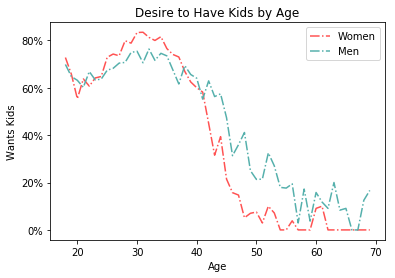

In [119]:
fig, ax = plt.subplots()

plt.plot(age_sex_kids['age'], age_sex_kids['f'], color='#FF5252', label='Women', linestyle='-.')
plt.plot(age_sex_kids['age'], age_sex_kids['m'], color = '#55B0AC', label='Men', linestyle='-.')

ticks = [i/100 for i in range(0,90,20)]
ax.set_yticks(ticks)
ax.set_yticklabels(['{:.0f}%'.format(i*100) for i in ticks])
plt.ylabel('Wants Kids')
plt.xlabel('Age')

plt.title('Desire to Have Kids by Age')

plt.legend()

plt.show()

In [120]:
df_mc['female'] = df_mc['sex'].apply(lambda x: 1 if x=='f' else 0)

feature_data = df_mc[['age', 'female','edu_level_num','wants kids_num']]
feature_data = feature_data[feature_data['age']<80]

x = feature_data.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
feature_data = pd.DataFrame(x_scaled, columns=feature_data.columns)

feature_data=feature_data.dropna()
feature_data.head(10)

,age,female,edu_level_num,wants kids_num
0,0.078431,0.0,0.666667,1.0
1,0.333333,0.0,0.333333,1.0
3,0.098039,0.0,0.666667,0.0
5,0.215686,0.0,0.666667,1.0
7,0.254902,1.0,0.666667,1.0
14,0.215686,1.0,0.666667,1.0
21,0.078431,1.0,0.666667,1.0
22,0.235294,0.0,0.666667,1.0
25,0.196078,0.0,0.666667,1.0
31,0.176471,0.0,0.666667,1.0


In [121]:
training_data, validation_data, training_labels, validation_labels = train_test_split(feature_data[['female','edu_level_num', 'age']], feature_data['wants kids_num'], train_size = 0.8, random_state = 100)


/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [122]:
start_time = time.time()

performance = {}
#kern_opt = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
#kern_opt = ['poly']

for g in range(1,10):
    for c in [x * 0.5 for x in range(1, 20)]:
        classifier = SVC(kernel='rbf', gamma = g, C=c)
        classifier.fit(training_data, training_labels)

        performance[(g,c)]=classifier.score(validation_data, validation_labels)
        
best = max(performance, key=performance.get)
print(best)

print("--- {:.3f} seconds ---".format((time.time() - start_time)))

(7, 2.0)
--- 725.689 seconds ---


In [123]:
classifier = SVC(gamma = best[0], C=best[1])
classifier.fit(training_data, training_labels)
print("Accuracy: {:.2f}%".format(100*classifier.score(validation_data, validation_labels)))

Accuracy: 72.34%


In [124]:
confusion_matrix = metrics.confusion_matrix(validation_labels, classifier.predict(validation_data))

accuracy = (confusion_matrix[0][0] + confusion_matrix[1][1])/confusion_matrix.sum()
precision = confusion_matrix[0][0]/(confusion_matrix[0][0] + confusion_matrix[1][0])
recall = confusion_matrix[0][0]/(confusion_matrix[0][0] + confusion_matrix[0][1])
f_1  = 2 * ((precision * recall)/(precision + recall))

print(confusion_matrix)
print('\n')
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1: {:.4f}".format(f_1))

[[ 281  605]
 [  68 1479]]


Accuracy: 0.7234
Precision: 0.8052
Recall: 0.3172
F1: 0.4551


In [125]:
print(sum(classifier.predict(validation_data)),"/", sum(validation_labels))

2084.0 / 1547.0


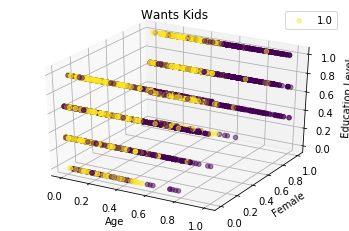

In [126]:
fig_3d = plt.figure()
ax = fig_3d.add_subplot(1, 1, 1, projection="3d")

ax.scatter(feature_data['age'], feature_data['female'], feature_data['edu_level_num'], c=feature_data['wants kids_num'], alpha=0.5, marker = 'o')

plt.title("Wants Kids")
ax.set_xlabel('Age')
ax.set_ylabel('Female')
ax.set_zlabel('Education Level')
plt.legend(feature_data['wants kids_num'])

plt.show()

/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


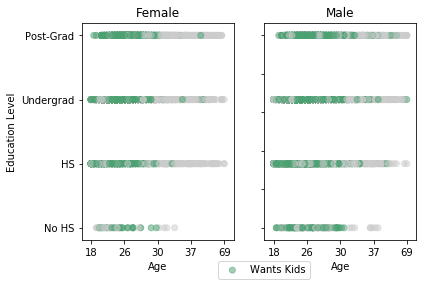

In [127]:
feature_data['color']=feature_data['wants kids_num'].map({0:'#cccccc', 1:'#4BA172'})

fig, ax = plt.subplots(1, 2)

ax[0].scatter(feature_data[feature_data['female']==1]['age'], feature_data[feature_data['female']==1]['edu_level_num'], c=feature_data[feature_data['female']==1]['color'],label=[feature_data[feature_data['female']==1]['wants kids_num']], alpha=0.5, marker = 'o')
ax[0].set_title("Female")
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Education Level')
#draw_boundary(ax[0], classifier, female=1)

yticks = sorted(list(feature_data[feature_data['female']==1]['edu_level_num'].unique()))
ax[0].set_yticks(yticks)
ax[0].set_yticklabels(['No HS', 'HS', 'Undergrad', 'Post-Grad'])

xticks = range(0,101,25)
ax[0].set_xticks([i/100 for i in xticks])
ax[0].set_xticklabels(["{:.0f}".format(np.nanpercentile(df_mc[df_mc['age']<80]['age'], i)) for i in xticks])


ax[1].scatter(feature_data[feature_data['female']==0]['age'], feature_data[feature_data['female']==0]['edu_level_num'], c=feature_data[feature_data['female']==0]['color'], label=feature_data[feature_data['female']==1]['wants kids_num'], alpha=0.5, marker = 'o')
ax[1].set_title("Male")
ax[1].set_xlabel('Age')
ax[1].set_yticklabels('')

ax[1].set_xticks([i/100 for i in xticks])
ax[1].set_xticklabels(["{:.0f}".format(np.nanpercentile(df_mc[df_mc['age']<80]['age'], i)) for i in xticks])


plt.legend(feature_data['wants kids_num'].unique(), labels=['Wants Kids'],loc = 'lower center', bbox_to_anchor=(0, -0.2))


#draw_boundary(ax[1], classifier, female=0)


plt.show()



In [128]:
start_time = time.time()

accuracies = []
for k in range(1, 200):
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(training_data, training_labels)
    accuracies.append(classifier.score(validation_data, validation_labels))

best = accuracies.index(max(accuracies)) + 1

print("--- {:.3f} seconds ---".format((time.time() - start_time)))

--- 26.214 seconds ---


In [129]:
classifier = KNeighborsClassifier(n_neighbors = best)
classifier.fit(training_data, training_labels)

print("Accuracy: {:.2f}%".format(100*classifier.score(validation_data, validation_labels)))

#accuracy = (true_positives + true_negatives) / len(guesses)
#recall = (true_positives)/(true_positives + false_negatives)
#precision = true_positives / (true_positives + false_positives)
#f_1 = 2 * ((precision * recall)/(precision + recall))

Accuracy: 72.46%


In [130]:
confusion_matrix = metrics.confusion_matrix(validation_labels, classifier.predict(validation_data))

accuracy = (confusion_matrix[0][0] + confusion_matrix[1][1])/confusion_matrix.sum()
precision = confusion_matrix[0][0]/(confusion_matrix[0][0] + confusion_matrix[1][0])
recall = confusion_matrix[0][0]/(confusion_matrix[0][0] + confusion_matrix[0][1])
f_1  = 2 * ((precision * recall)/(precision + recall))

print(confusion_matrix)
print('\n')
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1: {:.4f}".format(f_1))

[[ 293  593]
 [  77 1470]]


Accuracy: 0.7246
Precision: 0.7919
Recall: 0.3307
F1: 0.4666


In [131]:
print(sum(classifier.predict(validation_data)),"/", sum(validation_labels))

2063.0 / 1547.0


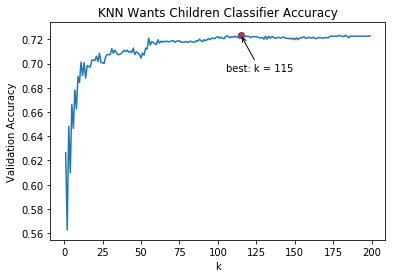

In [132]:
fig, ax = plt.subplots()
plt.plot(range(1, 200), accuracies)
plt.scatter(best, accuracies[best], color='red')
plt.xlabel("k")
plt.ylabel("Validation Accuracy")
plt.title("KNN Wants Children Classifier Accuracy")
ax.annotate('best: k = {}'.format(best), (best, accuracies[best]), xytext=(best-10, accuracies[best]-.03),arrowprops=dict(facecolor='black', arrowstyle="->"))
plt.show()

## Regressions

### Cleaning Data & Making Train/Test sets

In [133]:
df_mc['age_decile'] = pd.qcut(df_mc['age'], 10, duplicates='drop',labels=False)

df_mc['tech']=df_mc.job.apply(lambda x: 1 if (x=='science / tech / engineering') or (x=='computer / hardware / software') else 0)

In [134]:
regression_df = df_mc[(df_mc['age']<80)][['tech','has kids_num', 'age_decile', 'drinks_code', 'drugs_code', 'distance']].dropna()
X = regression_df[['tech','has kids_num', 'age_decile', 'drinks_code', 'drugs_code']]
y = regression_df['distance']

In [135]:
training_data, validation_data, training_labels, validation_labels = train_test_split(X, y, train_size = 0.8, random_state = 100)


/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Linear Regression

In [136]:
regr = LinearRegression()

regr.fit(training_data, training_labels)
print(regr.intercept_, list(zip(X.columns, regr.coef_)))

16.68392972371687 [('tech', 7.138986122356452), ('has kids_num', 5.155283200909941), ('age_decile', -0.8444727802434795), ('drinks_code', -0.8281508733182013), ('drugs_code', -0.8100762948265063)]


/Users/kerrydriscoll/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [137]:
regr.score(validation_data, validation_labels)

0.00025165492038614623

### KNeighbors Regressor

In [138]:
accuracies = []
for k in range(1, 200):
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(training_data, training_labels) 
    accuracies.append(neigh.score(validation_data, validation_labels))
    
best = accuracies.index(max(accuracies)) + 1

In [139]:
best

167

In [140]:
neigh = KNeighborsRegressor(n_neighbors=best)
neigh.fit(training_data, training_labels)
neigh.score(validation_data, validation_labels)

-0.0009023098345781744

In [141]:
df_mc.groupby('has kids_num')['distance'].describe()

,count,mean,std,min,25%,50%,75%,max
has kids_num,,,,,,,,
0.0,16132.0,11.632210,113.127134,0.0,0.0,0.000000,10.431904,5892.492043
1.0,4919.0,14.636204,76.245158,0.0,0.0,10.431904,17.321346,2571.927068


In [142]:
df_mc.groupby('tech')['distance'].describe()

,count,mean,std,min,25%,50%,75%,max
tech,,,,,,,,
0,50389.0,10.756768,98.954126,0.0,0.0,0.0,10.431904,7642.555566
1,9557.0,12.034490,135.418625,0.0,0.0,0.0,10.431904,5892.492043
